# Ising model
> a mathematical model for phase transitions


## About

In this notebook, we simulate the Ising model in 1D. The Ising model plays a central role in the theory of phase transitions. It is a mathematical model of ferromagnetism (for example, iron can be magnetized in a magnetic field, but if heated, it loses magnetization beyond Curie temperature). This blog contains Python code and a detailed algorithm for the [Monte Carlo simulation of the Ising model](#MC_Ising). A corresponding numerical simulation of a continuum description of the Ising model is also provided [below](#kinetic_ising).

The Ising model is named after Ernst Ising, Ph.D. in Physics (1924) from the University of Hamburg under the supervision of Wilhelm Lenz. Ising solved the one-dimensional (1D) Ising model exactly to find no phase transition. He also provided arguments on why there would not be a phase transition in higher dimensions either. In 1936, Peierls argued that both 2D and 3D Ising models admit phase transitions.

The Ising Hamiltonian can be written as,

$$
 {H} = -J \sum_{\langle i j \rangle} \sigma_{i} \sigma_{j}.  
$$

* The spins $\sigma_{i}$ can take values $\pm 1$,
*  $\langle i j \rangle$ implies nearest-neighbor interaction only,
* $J>0$ is the strength of exchange interaction.


The system undergoes a second order phase transition at the critical temperature $T_{c}$. For temperatures less than $T_{c}$, the system magnetizes, and the state is called the ferromagnetic or the ordered state. This amounts to a globally ordered state due to the presence of local interactions between the spin. For temperatures greater than $T_{c}$, the system is in the disordered or the paramagnetic state. In this case, there are no long-range correlations between the spins.

The order parameter

$$ m = \frac{1}{N}\sum_i \sigma_i $$

for this system is the average magnetization. The order parameter distinguishes the two phases realized by the systems. It is zero in the disordered state, while non-zero in the ordered, ferromagnetic, state.




In [1]:
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
from numba import jit

In [2]:
#----------------------------------------------------------------------
##  BLOCK OF FUNCTIONS USED IN THE MAIN CODE
#----------------------------------------------------------------------

def initialstate(N):
    ''' generates a random spin configuration for initial condition'''
    # NxN matrix with random inters -1,1
    state = 2*np.random.randint(2, size=(1,N))-1
    return state



@jit(nopython=False)
def mcmove(config, beta):
    '''Monte Carlo move using Metropolis algorithm '''

    #Config is the NxN spin matrix configuration
    #In each iteration NxN updates

    for i in range(N):
        b = np.random.randint(0, N)
        s =  config[0,b]
        nb = config[0,(b+1)%N] + config[0,(b-1)%N]
        #print nb
        cost = 2*s*nb
        if cost < 0:
            s *= -1
        elif rand() < np.exp(-cost*beta):
            s *= -1
        config[0,b] = s
    #print config
    return config




def calcEnergy(config):
    '''Energy of a given configuration'''
    energy = 0
    for i in range(N):
        S = config[0,i]
        nb = config[0,(i+1)%N] + config[0,(i-1)%N]
        #print nb
        energy += -nb*S
    return energy/2.    #Divide by 4 ensures , avoid multiple counting


def calcMag(config):
    '''Magnetization of a given configuration'''
    #magnetiation is just sum of all spins \sum_{i} S_i
    mag = np.sum(np.sum(config))
    return mag

In [3]:
## change the parameter below if you want to simulate a smaller system
nt      = 2**10        # number of temperature points
N       = 2**6        # size of the lattice, N
eqSteps = 2**8       # number of MC sweeps for equilibration
mcSteps = 2**8       # number of MC sweeps for calculation

n1, n2  = 1.0/(mcSteps*N*1), 1.0/(mcSteps*mcSteps*N*1)

#tm is the transition temperature
T=np.linspace(.01, 4, nt)

Energy       = np.zeros(nt);   Magnetization  = np.zeros(nt)
SpecificHeat = np.zeros(nt);   Susceptibility = np.zeros(nt)


#----------------------------------------------------------------------
#  MAIN PART OF THE CODE
#----------------------------------------------------------------------

#m is the temperature index

for m in range(len(T)):

    config = initialstate(N)
    iT=1.0/T[m]; iT2=iT*iT;

    for l in range(eqSteps):         # equilibrate
        mcmove(config, iT)           # Monte Carlo moves

    #Calculate quantities post equilibriation
    E1 = M1 = E2 = M2 = 0
    for i in range(mcSteps):
        mcmove(config, iT)
        Ene = calcEnergy(config)     # calculate the energy
        Mag = calcMag(config)        # calculate the magnetisation

        E1 = E1 + Ene                 #Cumulative energy
        M1 = M1 + Mag
        M2 = M2 + Mag*Mag
        E2 = E2 + Ene*Ene

        Energy[m]         = n1*E1     #Weighing for MC averages.
        Magnetization[m]  = n1*M1
        SpecificHeat[m]   = (n1*E2 - n2*E1*E1)*iT2
        Susceptibility[m] = (n1*M2 - n2*M1*M1)*iT2

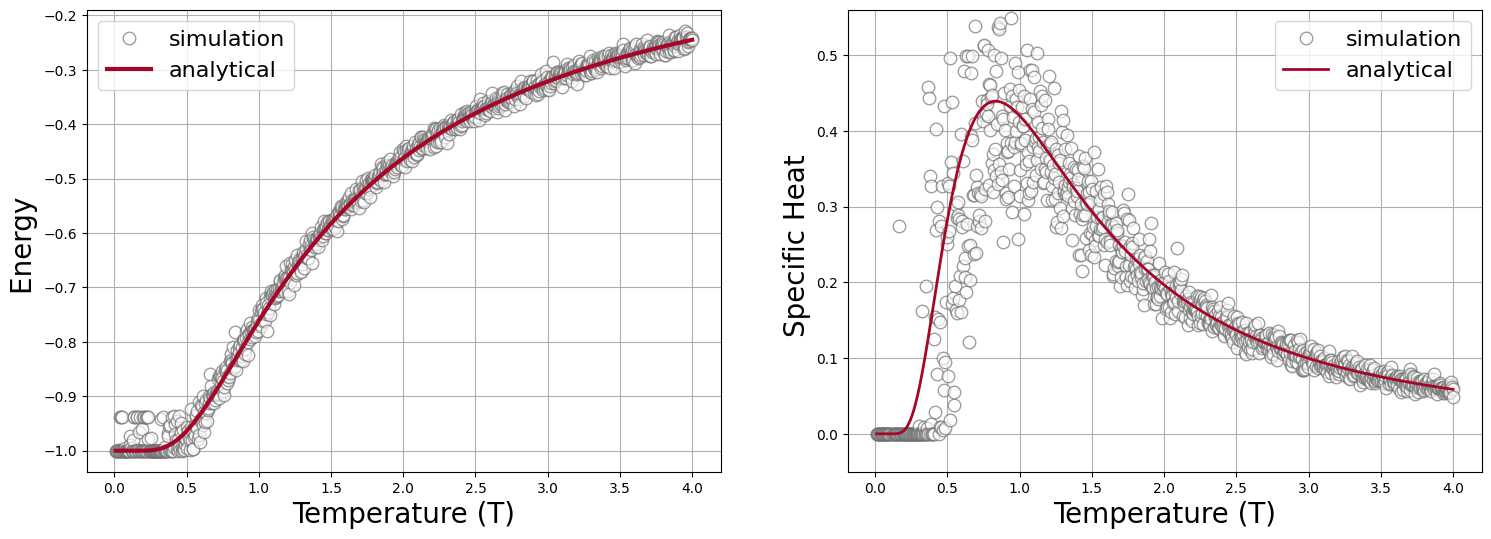

In [4]:
f = plt.figure(figsize=(18, 6)); # plot the calculated values

sp =  f.add_subplot(1, 2, 1 );
plt.plot(T, Energy, 'o', mec="dimgrey", mfc='w', ms=9, label='simulation', alpha=0.64);
plt.plot(T, -np.tanh(1.0/T), color="#A60628", lw=3, label='analytical' )
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Energy ", fontsize=20); plt.legend(fontsize=16)
plt.grid()

sp =  f.add_subplot(1, 2, 2 );
plt.plot(T, SpecificHeat, 'o', mec="dimgrey", mfc='w', ms=9, label='simulation', alpha=0.64);
plt.plot(T, (1.0/T**2)*(np.cosh(1.0/T))**(-2), color="#A60628", lw=2,label='analytical')
plt.xlabel("Temperature (T)", fontsize=20); plt.ylim([-0.05, .56])
plt.ylabel("Specific Heat ", fontsize=20);  plt.legend(fontsize=16)
plt.grid()

## Energy

$$
U=-\frac{\partial \ln Z}{\partial \beta}=-NJ\tanh \beta J
$$

## Specific heat

$$
C=\frac{\partial U}{\partial T} = N\frac{J^2}{k_BT^2} \text{sech}^2\beta J
$$

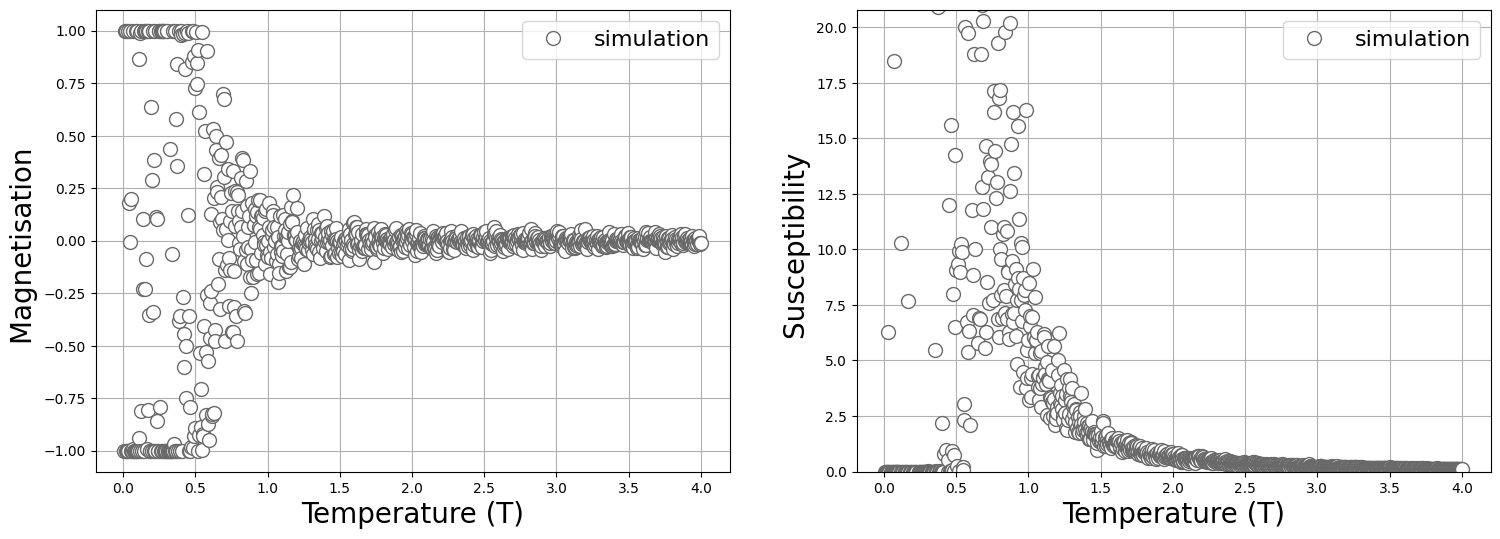

In [5]:
f = plt.figure(figsize=(18, 6)); # plot the calculated values

sp =  f.add_subplot(1, 2, 1 );
plt.plot(T, Magnetization, 'o', mec="dimgrey", mfc='w',ms=10, label='simulation');
# plt.plot(T, -np.tanh(1.0/T), color="#A60628", lw=3,label='analytical')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Magnetisation ", fontsize=20); plt.legend(fontsize=16)
plt.grid()

sp =  f.add_subplot(1, 2, 2 );
plt.plot(T, Susceptibility, 'o', mec="dimgrey", mfc='w',ms=10,  label='simulation');
plt.xlabel("Temperature (T)", fontsize=20); plt.ylim([-0.01, 20.8])
plt.ylabel("Susceptibility ", fontsize=20);  plt.legend(fontsize=16)
plt.grid()